In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from pathlib import Path

# Import our model from mediumModel.py
from mediumModel import (
    EnhancedFeatureExtractionNetwork,
    EnhancedPhaseCorrelationTensorComputation,
    DimensionAdapter,
    ManifoldLearningModule,
    PointCloudGenerator,
    TinyTopologicalFeatureExtraction,
    ClassificationNetwork,
    ImagePreprocessor
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Initialize model components from mediumModel.py with medium-sized parameters
feature_network = EnhancedFeatureExtractionNetwork(feature_dim=256).to(device)
tensor_computer = EnhancedPhaseCorrelationTensorComputation(feature_dim=256, output_dim=512).to(device)

# Create the dimension adapter
dim_adapter = DimensionAdapter(input_dim=512, output_dim=256).to(device)

# Initialize the manifold module
manifold_module = ManifoldLearningModule(
    input_dim=256,
    hidden_dim=512,
    latent_dim=64,
    gnn_hidden_dim=128
).to(device)

# For topological analysis, we need to create point clouds from manifold features
point_cloud_generator = PointCloudGenerator(num_points=64).to(device)

# Use TinyTopologicalFeatureExtraction from mediumModel.py
topo_module = TinyTopologicalFeatureExtraction(
    input_dim=64,           # Match the output dimension from ManifoldLearningModule
    hidden_dim=64,          # Hidden dimension
    output_dim=32,          # Output dimension
    max_edge_length=2.0,    # Maximum edge length for filtration
    num_filtrations=16,     # Number of filtration values
    max_dimension=1         # Increased to dimension 1 for medium model
).to(device)

# ClassificationNetwork from mediumModel.py
classifier = ClassificationNetwork(
    manifold_dim=64,        # Match the output dimension from ManifoldLearningModule
    topo_dim=32,            # Match the output dimension from TinyTopologicalFeatureExtraction
    feature_dim=128,        # Feature dimension
    hidden_dim=256,         # Hidden dimension
    num_layers=4,           # Number of transformer layers
    num_heads=6,            # Number of attention heads
    dropout=0.15            # Dropout rate
).to(device)

# Print model sizes using count_parameters from test_medium_model.py
from test_medium_model import count_parameters

print(f"Enhanced Feature Extraction Network: {count_parameters(feature_network):,} parameters")
print(f"Phase Correlation Tensor Computation: {count_parameters(tensor_computer):,} parameters")
print(f"Dimension Adapter: {count_parameters(dim_adapter):,} parameters")
print(f"Manifold Learning Module: {count_parameters(manifold_module):,} parameters")
print(f"Point Cloud Generator: {count_parameters(point_cloud_generator):,} parameters")
print(f"Tiny Topological Feature Extraction: {count_parameters(topo_module):,} parameters")
print(f"Classification Network: {count_parameters(classifier):,} parameters")
total_params = (count_parameters(feature_network) + count_parameters(tensor_computer) + 
               count_parameters(dim_adapter) + count_parameters(manifold_module) + 
               count_parameters(point_cloud_generator) + count_parameters(topo_module) + 
               count_parameters(classifier))
print(f"Total: {total_params:,} parameters")

Using device: cuda
Enhanced Feature Extraction Network: 23,825,059 parameters
Phase Correlation Tensor Computation: 7,324,353 parameters
Dimension Adapter: 1,869,184 parameters
Manifold Learning Module: 12,427,264 parameters
Point Cloud Generator: 97 parameters
Tiny Topological Feature Extraction: 4,256 parameters
Classification Network: 1,084,580 parameters
Total: 46,534,793 parameters


CSV columns: ['Unnamed: 0', 'file_name', 'label']
First few rows of the CSV:
   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
Total images found: 79950
Natural images: 39975
AI-generated images: 39975
Batch shape: torch.Size([2, 3, 384, 384])
Labels: tensor([1, 0])


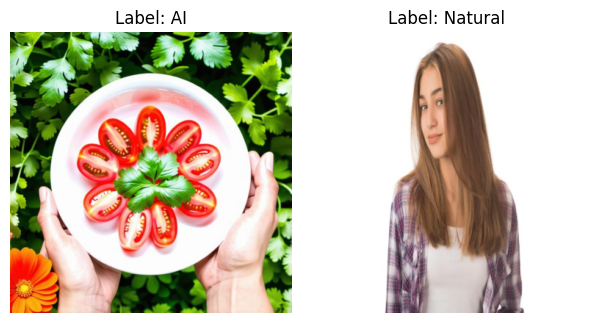

In [ ]:
# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_files, labels, target_size=(384, 384)):
        self.image_files = image_files
        self.labels = labels
        self.target_size = target_size
        
        # Define transforms using standard torchvision transformations
        self.transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label = self.labels[idx]
        
        try:
            # Open image with PIL and convert to RGB
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                img_tensor = self.transform(img)
                return img_tensor, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a placeholder tensor and the label
            return torch.ones(3, *self.target_size), label

            
# Load dataset from train.csv file
import pandas as pd

# Path to the CSV file - update this to your own path
csv_path = r'C:\Users\athar\Documents\GitHub\P.C.M\images\ai_vs_human_generated_dataset\train.csv' # Update this path
# Read the CSV file
df = pd.read_csv(csv_path)
print(f"CSV columns: {df.columns.tolist()}")
print(f"First few rows of the CSV:\n{df.head()}")

# Get the base path for the images
base_path = os.path.dirname(csv_path)

# Parse file paths and labels from CSV
all_files = []
labels = []

# Extract file paths and labels from the DataFrame
for index, row in df.iterrows():
    file_path = os.path.join(base_path, row['file_name'])
    label = int(row['label'])  # Assuming 0 = Natural, 1 = AI
    
    # Verify that the file exists
    if os.path.exists(file_path):
        all_files.append(file_path)
        labels.append(label)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Total images found: {len(all_files)}")
print(f"Natural images: {labels.count(0)}")
print(f"AI-generated images: {labels.count(1)}")

# Create the dataset with proper target size for our model
dataset = CustomImageDataset(all_files, labels, target_size=(384, 384))

# Split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders with appropriate batch size
batch_size = 2  # Start small due to model size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check a batch of data
try:
    images, labels = next(iter(train_loader))
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels}")
    
    # Visualize a few images
    plt.figure(figsize=(12, 6))
    for i in range(min(4, len(images))):
        plt.subplot(1, 4, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Label: {'Natural' if labels[i] == 0 else 'AI'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error loading batch: {e}")
    print("This might indicate issues with image loading or dataset structure.")

In [4]:
# Define loss functions
classification_criterion = nn.CrossEntropyLoss()

# Define optimizers - using separate optimizers for different components
# Adjust learning rates slightly for the medium model (slightly lower than small model)
feature_optimizer = optim.Adam(list(feature_network.parameters()) + 
                              list(tensor_computer.parameters()) + 
                              list(dim_adapter.parameters()), lr=8e-5)
manifold_optimizer = optim.Adam(manifold_module.parameters(), lr=8e-5)
topo_optimizer = optim.Adam(list(point_cloud_generator.parameters()) +
                           list(topo_module.parameters()), lr=8e-5)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=8e-5)

# Learning rate schedulers with adjusted patience for the medium model
feature_scheduler = optim.lr_scheduler.ReduceLROnPlateau(feature_optimizer, mode='min', 
                                                        factor=0.5, patience=3, min_lr=1e-6)
manifold_scheduler = optim.lr_scheduler.ReduceLROnPlateau(manifold_optimizer, mode='min', 
                                                         factor=0.5, patience=3, min_lr=1e-6)
topo_scheduler = optim.lr_scheduler.ReduceLROnPlateau(topo_optimizer, mode='min', 
                                                     factor=0.5, patience=3, min_lr=1e-6)
classifier_scheduler = optim.lr_scheduler.ReduceLROnPlateau(classifier_optimizer, mode='min', 
                                                           factor=0.5, patience=3, min_lr=1e-6)

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    """
    Computes the VAE loss function with robust handling for significant dimension mismatches.
    """
    # Check if reconstruction was successful
    if recon_x is None:
        # If decode failed, just use KL divergence
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.size(0)
    
    # Handle the specific case where recon_x is [batch_size, 768] and x is [batch_size, 256, 6, 6]
    if len(recon_x.shape) == 2 and len(x.shape) == 4:
        print(f"Handling dimension mismatch: recon_x {recon_x.size()} vs x {x.size()}")
        
        # Since recon_x seems to be a fixed size that doesn't match the flattened input,
        # we need a different approach than trying to reshape or compare directly
        
        # Option 1: Project recon_x to match the flattened size of x
        batch_size = x.size(0)
        flattened_size = x.view(batch_size, -1).size(1)
        
        # Create a projection layer on-the-fly if needed
        if not hasattr(vae_loss, 'projection_layer') or vae_loss.projection_layer.in_features != recon_x.size(1) or vae_loss.projection_layer.out_features != flattened_size:
            vae_loss.projection_layer = nn.Linear(recon_x.size(1), flattened_size).to(recon_x.device)
            # Initialize weights close to identity-like mapping
            nn.init.xavier_uniform_(vae_loss.projection_layer.weight)
            nn.init.zeros_(vae_loss.projection_layer.bias)
            print(f"Created new projection layer: {recon_x.size(1)} -> {flattened_size}")
        
        # Project recon_x to match flattened x dimensions
        projected_recon_x = vae_loss.projection_layer(recon_x)
        
        # Now compare with flattened x
        flattened_x = x.view(batch_size, -1)
        recon_loss = F.mse_loss(projected_recon_x, flattened_x, reduction='sum') / batch_size
        
        # KL divergence remains the same
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
        
        # Use a smaller weight for the KL term during early training
        kl_weight = min(0.8, 0.1 + 0.01 * getattr(vae_loss, 'call_count', 0))
        
        # Increment call count
        vae_loss.call_count = getattr(vae_loss, 'call_count', 0) + 1
        
        return recon_loss + kl_weight * kld_loss
    
    # For other shape mismatches, try to handle them appropriately
    elif recon_x.size() != x.size():
        print(f"Other dimension mismatch in VAE loss: recon_x {recon_x.size()} vs x {x.size()}")
        try:
            # Try to match dimensions by reshaping if possible
            batch_size = x.size(0)
            
            # If both can be flattened, use MSE on flattened versions
            recon_x_flat = recon_x.view(batch_size, -1)
            x_flat = x.view(batch_size, -1)
            
            # If dimensions still don't match, use a simpler approach
            if recon_x_flat.size(1) != x_flat.size(1):
                print(f"Cannot match dimensions even when flattened: {recon_x_flat.size()} vs {x_flat.size()}")
                # Just use KL divergence as the loss
                return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
            
            # If dimensions match after flattening
            recon_loss = F.mse_loss(recon_x_flat, x_flat, reduction='sum') / batch_size
            kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
            return recon_loss + 0.8 * kld_loss
            
        except Exception as e:
            print(f"Failed to handle VAE loss: {e}")
            # Fall back to just KL divergence if all else fails
            return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.size(0)
    
    # If shapes match exactly, use standard VAE loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + 0.8 * kld_loss

In [6]:
# 1. Adjust batch size and gradient accumulation for medium model
batch_size = 4  # Slightly larger than large model (2) but still conservative
gradient_accumulation_steps = 8  # More accumulation steps for medium model


# Training function with gradient accumulation for medium model
def train_epoch_with_accumulation(train_loader, epoch, accumulation_steps=8):
    # Set models to training mode
    feature_network.train()
    tensor_computer.train()
    dim_adapter.train()
    manifold_module.train()
    point_cloud_generator.train()
    topo_module.train()
    classifier.train()
    
    # Initialize metrics
    total_loss = 0
    total_feature_loss = 0
    total_manifold_loss = 0
    total_topo_loss = 0
    total_classifier_loss = 0
    correct = 0
    total = 0
    
    # Training loop
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    # Zero gradients at the start
    feature_optimizer.zero_grad()
    manifold_optimizer.zero_grad()
    topo_optimizer.zero_grad()
    classifier_optimizer.zero_grad()
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        try:
            # Forward pass through feature extraction
            features, _ = feature_network(images)
            phase_tensor = tensor_computer(features)
            
            # Apply dimension adapter to match channel count
            adapted_tensor = dim_adapter(phase_tensor)
            
            # Forward pass through manifold learning
            manifold_features, (mu, logvar, z) = manifold_module(adapted_tensor)
            
            # Reconstruct for VAE loss
            recon_tensor = manifold_module.decode(z)
            
            # Calculate manifold loss
            if recon_tensor is not None:
                # Use the VAE loss function with appropriate shape checking
                manifold_loss = vae_loss(recon_tensor, adapted_tensor, mu, logvar)
            else:
                # If the decoder is not fully initialized, use a simpler loss
                manifold_loss = torch.mean(mu.pow(2) + logvar.exp() - 1 - logvar)
            
            # Generate point cloud for topological analysis
            point_cloud = point_cloud_generator(manifold_features)
            
            # Forward pass through topological analysis
            topo_features, _ = topo_module(point_cloud)
            
            # Forward pass through classifier
            logits, probs, uncertainty = classifier(manifold_features, topo_features)
            
            # Compute losses
            classifier_loss = classification_criterion(logits, labels)
            
            # More meaningful feature extraction loss for medium model
            feature_loss = torch.mean(torch.abs(features)) * 0.01
            
            # More meaningful topological loss for medium model
            topo_loss = torch.mean(torch.abs(topo_features)) * 0.01
            
            # Combined loss with adjusted weighting for medium model
            loss = classifier_loss + 0.2 * manifold_loss + 0.05 * feature_loss + 0.05 * topo_loss
            
            # Scale losses by accumulation steps
            scaled_loss = loss / accumulation_steps
            
            # Backward pass
            scaled_loss.backward()
            
            # Update metrics
            total_feature_loss += feature_loss.item()
            total_manifold_loss += manifold_loss.item()
            total_topo_loss += topo_loss.item()
            total_classifier_loss += classifier_loss.item()
            total_loss += loss.item()
            
            # Calculate accuracy
            pred = logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
            
            # Only step optimizers after accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                # Apply gradient clipping for stability with medium model
                torch.nn.utils.clip_grad_norm_(feature_network.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(tensor_computer.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(dim_adapter.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(manifold_module.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(point_cloud_generator.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(topo_module.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
                
                feature_optimizer.step()
                manifold_optimizer.step()
                topo_optimizer.step()
                classifier_optimizer.step()
                
                # Zero gradients
                feature_optimizer.zero_grad()
                manifold_optimizer.zero_grad()
                topo_optimizer.zero_grad()
                classifier_optimizer.zero_grad()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': total_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
        
        except Exception as e:
            print(f"Error in training batch {batch_idx}: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for better debugging
            # Skip this batch and continue
            continue
    
    # Calculate epoch metrics
    avg_loss = total_loss / len(train_loader)
    avg_feature_loss = total_feature_loss / len(train_loader)
    avg_manifold_loss = total_manifold_loss / len(train_loader)
    avg_topo_loss = total_topo_loss / len(train_loader)
    avg_classifier_loss = total_classifier_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return {
        'loss': avg_loss,
        'feature_loss': avg_feature_loss,
        'manifold_loss': avg_manifold_loss,
        'topo_loss': avg_topo_loss,
        'classifier_loss': avg_classifier_loss,
        'accuracy': accuracy
    }

In [7]:
# Validation function for medium model
def validate(val_loader):
    # Set models to evaluation mode
    feature_network.eval()
    tensor_computer.eval()
    dim_adapter.eval()
    manifold_module.eval()
    point_cloud_generator.eval()
    topo_module.eval()
    classifier.eval()
    
    # Initialize metrics
    val_loss = 0
    val_feature_loss = 0
    val_manifold_loss = 0
    val_topo_loss = 0
    correct = 0
    total = 0
    
    # Store predictions and true labels for additional metrics
    all_preds = []
    all_labels = []
    all_probs = []
    all_uncertainty = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            try:
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                features, _ = feature_network(images)
                phase_tensor = tensor_computer(features)
                
                # Apply dimension adapter
                adapted_tensor = dim_adapter(phase_tensor)
                
                # Manifold learning
                manifold_features, (mu, logvar, z) = manifold_module(adapted_tensor)
                
                # Try to reconstruct for manifold evaluation
                recon_tensor = manifold_module.decode(z)
                
                # Calculate manifold loss if possible
                if recon_tensor is not None:
                    manifold_loss = vae_loss(recon_tensor, adapted_tensor, mu, logvar)
                else:
                    manifold_loss = torch.mean(mu.pow(2) + logvar.exp() - 1 - logvar)
                
                # Generate point cloud
                point_cloud = point_cloud_generator(manifold_features)
                
                # Topological analysis
                topo_features, _ = topo_module(point_cloud)
                
                # Classification
                logits, probs, uncertainty = classifier(manifold_features, topo_features)
                
                # Compute losses
                classification_loss = classification_criterion(logits, labels)
                feature_loss = torch.mean(torch.abs(features)) * 0.01
                topo_loss = torch.mean(torch.abs(topo_features)) * 0.01
                
                # Combined loss with adjusted weighting for medium model (same as training)
                loss = classification_loss + 0.2 * manifold_loss + 0.05 * feature_loss + 0.05 * topo_loss
                
                # Update metrics
                val_loss += loss.item()
                val_feature_loss += feature_loss.item()
                val_manifold_loss += manifold_loss.item()
                val_topo_loss += topo_loss.item()
                
                # Calculate accuracy
                pred = logits.argmax(dim=1)
                correct += pred.eq(labels).sum().item()
                total += labels.size(0)
                
                # Store for metrics
                all_preds.append(pred.cpu())
                all_labels.append(labels.cpu())
                all_probs.append(probs.cpu())
                all_uncertainty.append(uncertainty.cpu())
            
            except Exception as e:
                print(f"Error in validation: {e}")
                import traceback
                traceback.print_exc()  # Print full traceback for better debugging
                # Skip this batch and continue
                continue
    
    # Calculate metrics
    avg_loss = val_loss / len(val_loader)
    avg_feature_loss = val_feature_loss / len(val_loader)
    avg_manifold_loss = val_manifold_loss / len(val_loader)
    avg_topo_loss = val_topo_loss / len(val_loader)
    accuracy = 100. * correct / total
    
    # Concatenate predictions and labels
    if all_preds and all_labels and all_probs and all_uncertainty:
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        all_probs = torch.cat(all_probs)
        all_uncertainty = torch.cat(all_uncertainty)
    else:
        print("Warning: Some metrics could not be collected during validation")
        all_preds = torch.tensor([])
        all_labels = torch.tensor([])
        all_probs = torch.tensor([])
        all_uncertainty = torch.tensor([])
    
    return {
        'loss': avg_loss,
        'feature_loss': avg_feature_loss,
        'manifold_loss': avg_manifold_loss,
        'topo_loss': avg_topo_loss,
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'uncertainty': all_uncertainty
    }

# Function to save models - adjusted for medium model
def save_models(epoch=None, metrics=None):
    # Create directory if it doesn't exist
    os.makedirs('models/medium', exist_ok=True)
    
    # Add epoch information to filenames if provided
    suffix = f"_epoch{epoch}" if epoch is not None else ""
    
    # Save model states
    torch.save(feature_network.state_dict(), f'models/medium/feature_network{suffix}.pth')
    torch.save(tensor_computer.state_dict(), f'models/medium/tensor_computer{suffix}.pth')
    torch.save(dim_adapter.state_dict(), f'models/medium/dim_adapter{suffix}.pth')  
    torch.save(manifold_module.state_dict(), f'models/medium/manifold_module{suffix}.pth')
    torch.save(point_cloud_generator.state_dict(), f'models/medium/point_cloud_generator{suffix}.pth')
    torch.save(topo_module.state_dict(), f'models/medium/topo_module{suffix}.pth')
    torch.save(classifier.state_dict(), f'models/medium/classifier{suffix}.pth')
    
    # Save optimizer states
    torch.save(feature_optimizer.state_dict(), f'models/medium/feature_optimizer{suffix}.pth')
    torch.save(manifold_optimizer.state_dict(), f'models/medium/manifold_optimizer{suffix}.pth')
    torch.save(topo_optimizer.state_dict(), f'models/medium/topo_optimizer{suffix}.pth')
    torch.save(classifier_optimizer.state_dict(), f'models/medium/classifier_optimizer{suffix}.pth')
    
    # Save scheduler states
    torch.save(feature_scheduler.state_dict(), f'models/medium/feature_scheduler{suffix}.pth')
    torch.save(manifold_scheduler.state_dict(), f'models/medium/manifold_scheduler{suffix}.pth')
    torch.save(topo_scheduler.state_dict(), f'models/medium/topo_scheduler{suffix}.pth')
    torch.save(classifier_scheduler.state_dict(), f'models/medium/classifier_scheduler{suffix}.pth')
    
    # Save metrics if provided
    if metrics is not None:
        # Convert tensors to lists for JSON serialization
        serializable_metrics = {}
        for k, v in metrics.items():
            if isinstance(v, torch.Tensor):
                serializable_metrics[k] = v.tolist()
            else:
                serializable_metrics[k] = v
        
        import json
        with open(f'models/medium/metrics{suffix}.json', 'w') as f:
            json.dump(serializable_metrics, f)
    
    print(f"Medium model saved to models/medium/ directory{' for epoch ' + str(epoch) if epoch is not None else ''}")

In [10]:
# Training parameters - adjusted for medium model
num_epochs = 15  # Increased from 10 to allow more training time for larger model
gradient_accumulation_steps = 8  # Matches the value set earlier
best_val_accuracy = 0
early_stopping_patience = 5  # Added early stopping
early_stopping_counter = 0

# Save frequency - save every N batches within an epoch
save_frequency = 50  # Save every 50 batches

# Metrics tracking - more comprehensive for medium model
train_losses = []
train_feature_losses = []
train_manifold_losses = []
train_topo_losses = []
train_classifier_losses = []
train_accuracies = []
val_losses = []
val_feature_losses = []
val_manifold_losses = []
val_topo_losses = []
val_accuracies = []
val_uncertainties = []
learning_rates = []  # Track learning rates

# Create results directory for medium model
os.makedirs('results/medium', exist_ok=True)
os.makedirs('models/medium/checkpoints', exist_ok=True)  # For intermediate checkpoints

# Modified training function with intermediate checkpoints
def train_epoch_with_checkpoints(train_loader, epoch, accumulation_steps=8, checkpoint_freq=50):
    # Set models to training mode
    feature_network.train()
    tensor_computer.train()
    dim_adapter.train()
    manifold_module.train()
    point_cloud_generator.train()
    topo_module.train()
    classifier.train()
    
    # Initialize metrics
    total_loss = 0
    total_feature_loss = 0
    total_manifold_loss = 0
    total_topo_loss = 0
    total_classifier_loss = 0
    correct = 0
    total = 0
    
    # Initialize batch-level metrics for early detection
    batch_losses = []
    
    # Training loop with checkpoints
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    # Zero gradients at the start
    feature_optimizer.zero_grad()
    manifold_optimizer.zero_grad()
    topo_optimizer.zero_grad()
    classifier_optimizer.zero_grad()
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        try:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass through feature extraction
            features, _ = feature_network(images)
            phase_tensor = tensor_computer(features)
            
            # Apply dimension adapter to match channel count
            adapted_tensor = dim_adapter(phase_tensor)
            
            # Forward pass through manifold learning
            manifold_features, (mu, logvar, z) = manifold_module(adapted_tensor)
            
            # Reconstruct for VAE loss
            recon_tensor = manifold_module.decode(z)
            
            # Calculate manifold loss with robust error handling
            if recon_tensor is not None:
                try:
                    manifold_loss = vae_loss(recon_tensor, adapted_tensor, mu, logvar)
                except Exception as e:
                    print(f"Error in VAE loss calculation: {e}")
                    # Fallback to KL divergence only
                    manifold_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.size(0)
            else:
                # If the decoder is not fully initialized, use a simpler loss
                manifold_loss = torch.mean(mu.pow(2) + logvar.exp() - 1 - logvar)
            
            # Generate point cloud for topological analysis
            point_cloud = point_cloud_generator(manifold_features)
            
            # Forward pass through topological analysis
            topo_features, _ = topo_module(point_cloud)
            
            # Forward pass through classifier
            logits, probs, uncertainty = classifier(manifold_features, topo_features)
            
            # Compute losses
            classifier_loss = classification_criterion(logits, labels)
            
            # More meaningful feature extraction loss for medium model
            feature_loss = torch.mean(torch.abs(features)) * 0.01
            
            # More meaningful topological loss for medium model
            topo_loss = torch.mean(torch.abs(topo_features)) * 0.01
            
            # Combined loss with adjusted weighting for medium model
            loss = classifier_loss + 0.2 * manifold_loss + 0.05 * feature_loss + 0.05 * topo_loss
            
            # Check for NaN loss - early detection
            if torch.isnan(loss) or torch.isinf(loss) or loss > 1000:
                print(f"\nWARNING: Abnormal loss value detected: {loss.item()}")
                print(f"  Feature loss: {feature_loss.item()}")
                print(f"  Manifold loss: {manifold_loss.item()}")
                print(f"  Topo loss: {topo_loss.item()}")
                print(f"  Classifier loss: {classifier_loss.item()}")
                
                # Save emergency checkpoint
                save_models(epoch=f"{epoch}_batch{batch_idx}_emergency")
                
                # Either skip this batch or raise an exception to stop training
                if loss > 10000:  # Very abnormal loss
                    raise ValueError(f"Training stopped due to extremely high loss: {loss.item()}")
                else:
                    # Skip this batch and continue
                    print("Skipping this batch and continuing...")
                    feature_optimizer.zero_grad()
                    manifold_optimizer.zero_grad()
                    topo_optimizer.zero_grad()
                    classifier_optimizer.zero_grad()
                    continue
            
            # Track batch-level metrics for early problem detection
            batch_losses.append(loss.item())
            if len(batch_losses) > 5:  # Check trend over last few batches
                if all(l > 1000 for l in batch_losses[-3:]):  # 3 consecutive high losses
                    print("\nWARNING: Multiple consecutive batches with high loss. Saving checkpoint and continuing.")
                    save_models(epoch=f"{epoch}_batch{batch_idx}_highLoss")
            
            # Scale losses by accumulation steps
            scaled_loss = loss / accumulation_steps
            
            # Backward pass
            scaled_loss.backward()
            
            # Update metrics
            total_feature_loss += feature_loss.item()
            total_manifold_loss += manifold_loss.item()
            total_topo_loss += topo_loss.item()
            total_classifier_loss += classifier_loss.item()
            total_loss += loss.item()
            
            # Calculate accuracy
            pred = logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
            
            # Only step optimizers after accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                # Apply gradient clipping for stability with medium model
                torch.nn.utils.clip_grad_norm_(feature_network.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(tensor_computer.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(dim_adapter.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(manifold_module.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(point_cloud_generator.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(topo_module.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
                
                feature_optimizer.step()
                manifold_optimizer.step()
                topo_optimizer.step()
                classifier_optimizer.step()
                
                # Zero gradients
                feature_optimizer.zero_grad()
                manifold_optimizer.zero_grad()
                topo_optimizer.zero_grad()
                classifier_optimizer.zero_grad()
            
            # Save checkpoint at specified frequency
            if (batch_idx + 1) % checkpoint_freq == 0:
                # Calculate current metrics
                current_accuracy = 100. * correct / total if total > 0 else 0
                
                # Save checkpoint
                checkpoint_path = f'models/medium/checkpoints/epoch{epoch}_batch{batch_idx}'
                os.makedirs(checkpoint_path, exist_ok=True)
                
                torch.save(feature_network.state_dict(), f'{checkpoint_path}/feature_network.pth')
                torch.save(tensor_computer.state_dict(), f'{checkpoint_path}/tensor_computer.pth')
                torch.save(dim_adapter.state_dict(), f'{checkpoint_path}/dim_adapter.pth')
                torch.save(manifold_module.state_dict(), f'{checkpoint_path}/manifold_module.pth')
                torch.save(point_cloud_generator.state_dict(), f'{checkpoint_path}/point_cloud_generator.pth')
                torch.save(topo_module.state_dict(), f'{checkpoint_path}/topo_module.pth')
                torch.save(classifier.state_dict(), f'{checkpoint_path}/classifier.pth')
                
                print(f"\nCheckpoint saved at batch {batch_idx+1} with accuracy: {current_accuracy:.2f}%")
            
            # Update progress bar
            if batch_idx % 10 == 0:  # Update less frequently to reduce overhead
                progress_bar.set_postfix({
                    'loss': total_loss / (batch_idx + 1),
                    'acc': 100. * correct / total if total > 0 else 0
                })
        
        except Exception as e:
            print(f"\nError in training batch {batch_idx}: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for better debugging
            
            # Save emergency checkpoint
            save_models(epoch=f"{epoch}_batch{batch_idx}_error")
            
            # Decide whether to continue or raise the exception
            if "CUDA out of memory" in str(e):
                print("CUDA out of memory error detected. Attempting to free memory and continue...")
                torch.cuda.empty_cache()  # Try to free GPU memory
                
                # Skip this batch and continue
                feature_optimizer.zero_grad()
                manifold_optimizer.zero_grad()
                topo_optimizer.zero_grad()
                classifier_optimizer.zero_grad()
                continue
            else:
                # For non-memory errors, it might be best to raise the exception
                # to stop training and debug
                raise
    
    # Calculate epoch metrics
    avg_loss = total_loss / len(train_loader)
    avg_feature_loss = total_feature_loss / len(train_loader)
    avg_manifold_loss = total_manifold_loss / len(train_loader)
    avg_topo_loss = total_topo_loss / len(train_loader)
    avg_classifier_loss = total_classifier_loss / len(train_loader)
    accuracy = 100. * correct / total if total > 0 else 0
    
    return {
        'loss': avg_loss,
        'feature_loss': avg_feature_loss,
        'manifold_loss': avg_manifold_loss,
        'topo_loss': avg_topo_loss,
        'classifier_loss': avg_classifier_loss,
        'accuracy': accuracy
    }

# Training loop with improved error handling
print(f"Starting training for medium model ({total_params:,} parameters)")
try:
    for epoch in range(1, num_epochs + 1):
        try:
            print(f"\n{'='*80}\nEpoch {epoch}/{num_epochs}\n{'='*80}")
            
            # Train for one epoch using improved function with checkpoints
            train_metrics = train_epoch_with_checkpoints(
                train_loader, 
                epoch, 
                accumulation_steps=gradient_accumulation_steps,
                checkpoint_freq=save_frequency
            )
            
            # Store training metrics
            train_losses.append(train_metrics['loss'])
            train_feature_losses.append(train_metrics['feature_loss'])
            train_manifold_losses.append(train_metrics['manifold_loss'])
            train_topo_losses.append(train_metrics['topo_loss'])
            train_classifier_losses.append(train_metrics['classifier_loss'])
            train_accuracies.append(train_metrics['accuracy'])
            
            # Validate
            val_metrics = validate(val_loader)
            val_losses.append(val_metrics['loss'])
            val_feature_losses.append(val_metrics['feature_loss'])
            val_manifold_losses.append(val_metrics['manifold_loss'])
            val_topo_losses.append(val_metrics['topo_loss'])
            val_accuracies.append(val_metrics['accuracy'])
            
            # Store mean uncertainty
            if isinstance(val_metrics['uncertainty'], torch.Tensor) and len(val_metrics['uncertainty']) > 0:
                mean_uncertainty = val_metrics['uncertainty'].mean().item()
            else:
                mean_uncertainty = 0.0
            val_uncertainties.append(mean_uncertainty)
            
            # Store current learning rates
            current_lr = feature_optimizer.param_groups[0]['lr']
            learning_rates.append(current_lr)
            
            # Print detailed metrics
            print(f"Epoch {epoch}/{num_epochs}:")
            print(f"  Train Loss: {train_metrics['loss']:.4f}, Train Acc: {train_metrics['accuracy']:.2f}%")
            print(f"    Feature Loss: {train_metrics['feature_loss']:.4f}")
            print(f"    Manifold Loss: {train_metrics['manifold_loss']:.4f}")
            print(f"    Topo Loss: {train_metrics['topo_loss']:.4f}")
            print(f"    Classifier Loss: {train_metrics['classifier_loss']:.4f}")
            print(f"  Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.2f}%")
            print(f"    Mean Uncertainty: {mean_uncertainty:.4f}")
            print(f"  Learning Rate: {current_lr:.2e}")
            
            # Update learning rate schedulers
            feature_scheduler.step(val_metrics['loss'])
            manifold_scheduler.step(val_metrics['loss'])
            topo_scheduler.step(val_metrics['loss'])
            classifier_scheduler.step(val_metrics['loss'])
            
            # Early stopping check
            if epoch > 1 and val_metrics['accuracy'] <= best_val_accuracy:
                early_stopping_counter += 1
                print(f"  No improvement in validation accuracy. Early stopping counter: {early_stopping_counter}/{early_stopping_patience}")
                
                if early_stopping_counter >= early_stopping_patience:
                    print(f"  Early stopping triggered after {epoch} epochs")
                    break
            else:
                early_stopping_counter = 0
            
            # Save best model
            if val_metrics['accuracy'] > best_val_accuracy:
                best_val_accuracy = val_metrics['accuracy']
                print(f"  New best model with accuracy: {best_val_accuracy:.2f}%")
                
                # Save each component with epoch information
                save_models(epoch=epoch, metrics={
                    'train_loss': train_metrics['loss'],
                    'train_accuracy': train_metrics['accuracy'],
                    'val_loss': val_metrics['loss'],
                    'val_accuracy': val_metrics['accuracy'],
                    'mean_uncertainty': mean_uncertainty
                })
                
                # Save all metrics
                torch.save({
                    'train_losses': train_losses,
                    'train_feature_losses': train_feature_losses,
                    'train_manifold_losses': train_manifold_losses,
                    'train_topo_losses': train_topo_losses,
                    'train_classifier_losses': train_classifier_losses,
                    'train_accuracies': train_accuracies,
                    'val_losses': val_losses,
                    'val_feature_losses': val_feature_losses,
                    'val_manifold_losses': val_manifold_losses,
                    'val_topo_losses': val_topo_losses,
                    'val_accuracies': val_accuracies,
                    'val_uncertainties': val_uncertainties,
                    'learning_rates': learning_rates,
                    'best_epoch': epoch,
                    'best_accuracy': best_val_accuracy
                }, 'models/medium/training_metrics.pt')
            
            # Create and save plots after each epoch
            plt.figure(figsize=(15, 10))
            
            # Plot loss
            plt.subplot(2, 2, 1)
            plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
            plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
            plt.title('Total Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Plot component losses
            plt.subplot(2, 2, 2)
            plt.plot(range(1, len(train_feature_losses) + 1), train_feature_losses, label='Feature Loss')
            plt.plot(range(1, len(train_manifold_losses) + 1), train_manifold_losses, label='Manifold Loss')
            plt.plot(range(1, len(train_topo_losses) + 1), train_topo_losses, label='Topo Loss')
            plt.plot(range(1, len(train_classifier_losses) + 1), train_classifier_losses, label='Classifier Loss')
            plt.title('Component Losses')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Plot accuracy
            plt.subplot(2, 2, 3)
            plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
            plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
            plt.title('Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (%)')
            plt.legend()
            plt.grid(True)
            
            # Plot learning rate and uncertainty
            plt.subplot(2, 2, 4)
            ax1 = plt.gca()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Learning Rate', color='blue')
            ax1.plot(range(1, len(learning_rates) + 1), learning_rates, color='blue', label='Learning Rate')
            ax1.tick_params(axis='y', labelcolor='blue')
            
            ax2 = ax1.twinx()
            ax2.set_ylabel('Uncertainty', color='red')
            ax2.plot(range(1, len(val_uncertainties) + 1), val_uncertainties, color='red', label='Uncertainty')
            ax2.tick_params(axis='y', labelcolor='red')
            
            plt.title('Learning Rate and Uncertainty')
            plt.grid(True)
            
            plt.tight_layout()
            plt.savefig(f'results/medium/training_curves_epoch{epoch}.png')
            plt.close()
            
        except Exception as e:
            print(f"Error in epoch {epoch}: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for better debugging
            
            # Save emergency checkpoint
            save_models(epoch=f"{epoch}_emergency")
            
            # Check if we should continue or stop training
            if "CUDA out of memory" in str(e):
                print("CUDA out of memory error detected. Attempting to free memory and continue...")
                torch.cuda.empty_cache()  # Try to free GPU memory
                continue
            else:
                raise  # Re-raise the exception for other errors

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
    # Save checkpoint
    save_models(epoch="interrupted")
except Exception as e:
    print(f"\nTraining stopped due to error: {e}")
    traceback.print_exc()
    # Save emergency checkpoint
    save_models(epoch="error_final")
finally:
    # This will run regardless of how the training ends
    print("\nTraining complete or interrupted!")
    print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
    
    # Final save
    save_models(epoch="final")
    print("Final models saved to models/medium/ directory")
    
    # Save a text summary of the training
    with open('results/medium/training_summary.txt', 'w') as f:
        f.write(f"Medium Model Training Summary (Approx. {total_params:,} parameters)\n")
        f.write(f"{'='*80}\n\n")
        f.write(f"Best validation accuracy: {best_val_accuracy:.2f}%\n")
        
        if val_accuracies:
            best_epoch_idx = val_accuracies.index(max(val_accuracies))
            f.write(f"Best epoch: {best_epoch_idx + 1}\n\n")
            
            f.write("Final metrics:\n")
            if train_losses:
                f.write(f"  Train Loss: {train_losses[-1]:.4f}\n")
            if val_losses:
                f.write(f"  Validation Loss: {val_losses[-1]:.4f}\n")
            if train_accuracies:
                f.write(f"  Train Accuracy: {train_accuracies[-1]:.2f}%\n")
            if val_accuracies:
                f.write(f"  Validation Accuracy: {val_accuracies[-1]:.2f}%\n")
            if val_uncertainties:
                f.write(f"  Validation Uncertainty: {val_uncertainties[-1]:.4f}\n\n")
            
            f.write("Component metrics at best epoch:\n")
            if train_feature_losses:
                f.write(f"  Feature Loss: {train_feature_losses[best_epoch_idx]:.4f}\n")
            if train_manifold_losses:
                f.write(f"  Manifold Loss: {train_manifold_losses[best_epoch_idx]:.4f}\n")
            if train_topo_losses:
                f.write(f"  Topo Loss: {train_topo_losses[best_epoch_idx]:.4f}\n")
            if train_classifier_losses:
                f.write(f"  Classifier Loss: {train_classifier_losses[best_epoch_idx]:.4f}\n")
        else:
            f.write("No validation metrics were recorded during training.\n")
    
    print("Training summary saved to results/medium/training_summary.txt")

Starting training for medium model (46,534,793 parameters)

Epoch 1/15


Epoch 1:   0%|          | 0/31980 [00:00<?, ?it/s]

Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling dimension mismatch: recon_x torch.Size([2, 768]) vs x torch.Size([2, 256, 6, 6])
Handling d